<a href="https://colab.research.google.com/github/Jonny55921/Deep-Q-Learning-on-Human-Cannonball/blob/main/starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**[Human Cannonball Environment (ALE)](https://ale.farama.org/environments/human_cannonball/#human-cannonball)**

#Environment
**Brief Description**: Shoot a person out of a cannonball and try to get them into the water tower.

**Observation space**: The default interface gymnasium.make("ALE/HumanCannonball-v5") uses an observation space of Box(0,255,(210,160,3), uint8) for the “rgb” option.

**Action Space**: Discrete(18)

0 = NOOP

1 = FIRE

2 = UP

3 = RIGHT

4 = LEFT

5 = DOWN

6 = UPRIGHT

7 = UPLEFT

8 = DOWNRIGHT

9 = DOWNLEFT

10 = UPFIRE

11 = RIGHTFIRE

12 = LEFTFIRE

13 = DOWNFIRE

14 = UPRIGHTFIRE

15 = UPLEFTFIRE

16 = DOWNRIGHTFIRE

17 = DOWNLEFTFIRE


**Reward Signal Quirks**: Sparse and Episodic

**Key Quirks for DQN study:**

*   Sparse rewards: many actions/steps until a hit or miss event.
*   Delayed outcome: the result (hit/miss) comes after a sequence of actions(angle adjustment, firing, trajectory) rather than every time‐step.
*   Episodic termination on failure or success: once a miss count or hit count threshold is reached, the game may reset.
*   Multiple modes/difficulties: distance, movement of target, barrier windows change difficulty, meaning different reward densities and dynamics depending on mode.


This environment presents a moderately challenging reinforcement learning task: the need to learn accurate angle/power/trajectory control via image input, sparse reward structure, and varying target dynamics across difficulty modes.



 # Install the Gym (Setup & Installs)

In [ ]:
!pip install gymnasium[atari,accept-rom-license]
!pip install autorom
!pip install stable-baselines3
!AutoROM --accept-license

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 9.7 MB/s eta 0:00:00
AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/adventure.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/assault.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/asterix.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/asteroids.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/atlantis.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/atlantis2.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/backgammon.bin
In

# Imports & Mount Drive

In [ ]:
import ale_py
import gymnasium as gym
from gymnasium import spaces
from dataclasses import dataclass
import collections, typing as tt, time, os
from datetime import datetime
import numpy as np
import json
import imageio
import numpy as np
from base64 import b64encode
from IPython.display import HTML, display
import pandas as pd
from tabulate import tabulate
import torch, torch.nn as nn, torch.optim as optim
from stable_baselines3.common import atari_wrappers
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from google.colab import drive
drive.mount('/content/drive')

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Mounted at /content/drive


# Configure the model save drive

In [ ]:
save_dir = "/content/drive/MyDrive/PUBLIC/Models"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
#Reset TensorBoard experiment logs (safe even if folders don't exist)
import shutil, os

log_dirs = ["runs/baseline", "runs/ddqn", "runs/per", "runs/ddqn_per"]

print("Clearing old TensorBoard logs...")

for d in log_dirs:
    try:
        shutil.rmtree(d)
        print(f"Removed {d}")
    except FileNotFoundError:
        print(f"   • {d} did not exist, skipping.")

print("Ensuring directories exist...")
for d in log_dirs:
    os.makedirs(d, exist_ok=True)
    print(f"✔ Created {d}")

print("Log reset complete. Ready for new experiments!")


Clearing old TensorBoard logs...
   • runs/baseline did not exist, skipping.
   • runs/ddqn did not exist, skipping.
   • runs/per did not exist, skipping.
   • runs/ddqn_per did not exist, skipping.
Ensuring directories exist...
✔ Created runs/baseline
✔ Created runs/ddqn
✔ Created runs/per
✔ Created runs/ddqn_per
Log reset complete. Ready for new experiments!


## Environment Wrappers



In [ ]:
class ImageToPyTorch(gym.ObservationWrapper):
    """
    ImageToPyTorch: Reorders image dimensions from (H, W, C) to (C, H, W)
    for compatibility with PyTorch convolutional layers.
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        obs = self.observation_space
        assert isinstance(obs, gym.spaces.Box)
        assert len(obs.shape) == 3
        new_shape = (obs.shape[-1], obs.shape[0], obs.shape[1])
        self.observation_space = gym.spaces.Box(
            low=obs.low.min(), high=obs.high.max(),
            shape=new_shape, dtype=obs.dtype)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class BufferWrapper(gym.ObservationWrapper):
    """
    BufferWrapper: Maintains a rolling window of the last `n_steps` frames
    to give the agent a sense of temporal context.
    """
    def __init__(self, env, n_steps):
        super(BufferWrapper, self).__init__(env)
        obs = env.observation_space
        assert isinstance(obs, spaces.Box)
        new_obs = gym.spaces.Box(
            obs.low.repeat(n_steps, axis=0), obs.high.repeat(n_steps, axis=0),
            dtype=obs.dtype)
        self.observation_space = new_obs
        self.buffer = collections.deque(maxlen=n_steps)

    def reset(self, *, seed: tt.Optional[int] = None, options: tt.Optional[dict[str, tt.Any]] = None):
        for _ in range(self.buffer.maxlen):
            self.buffer.append(np.zeros_like(self.env.observation_space.low))
        obs, extra = self.env.reset()
        return self.observation(obs), extra

    def observation(self, observation: np.ndarray) -> np.ndarray:
        self.buffer.append(observation)
        return np.concatenate(self.buffer)


# Environment Setup

In [ ]:
def make_env(env_name: str, n_steps=4, render_mode=None, **kwargs):
    print(f"Creating environment {env_name}")
    env = gym.make(env_name, render_mode=render_mode, **kwargs)
    env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=n_steps)
    return env

DEFAULT_ENV_NAME = "ALE/HumanCannonball-v5"

# Configuration & Hyperparameters

In [ ]:
def save_hyperparams(hparams: dict, save_path: str):
    with open(save_path, "w") as f:
        json.dump(hparams, f, indent=4)
    print(f"Saved hyperparameters → {save_path}")

In [ ]:
experiment_log = []

def log_experiment_change(description: str):
    experiment_log.append(description)
    print("Logged change:", description)

In [ ]:
# Base Configuration
MEAN_REWARD_BOUND = 5 #19

GAMMA = 0.99
BATCH_SIZE = 16 # 32
REPLAY_SIZE = 5000 # 10000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 500 #1000
REPLAY_START_SIZE = 500 # 10000

SAVE_EPSILON = 0.5  # Only save if at least this much better
EPSILON_DECAY_LAST_FRAME = 5000 # 150000
EPSILON_START = 1.0
EPSILON_FINAL = 0.02 # 0.01

# Tuple of tensors returned from a sampled minibatch in replay buffer
State = np.ndarray
Action = int
BatchTensors = tt.Tuple[
    torch.ByteTensor,           # current state
    torch.LongTensor,           # actions
    torch.Tensor,               # rewards
    torch.BoolTensor,           # done || trunc
    torch.ByteTensor            # next state
]

In [ ]:
baseline_hparams = {
    "run_type": "Baseline DQN",
    "env_name": DEFAULT_ENV_NAME,
    "gamma": GAMMA,
    "batch_size": BATCH_SIZE,
    "replay_size": REPLAY_SIZE,
    "learning_rate": LEARNING_RATE,
    "optimizer": "Adam",
    "epsilon_start": EPSILON_START,
    "epsilon_final": EPSILON_FINAL,
    "epsilon_decay": EPSILON_DECAY_LAST_FRAME,
    "target_sync": SYNC_TARGET_FRAMES,
    "frame_stack": 4,
    "extension": "None",
    "replay_start_size": REPLAY_START_SIZE
}

# Model Save Directories

In [ ]:
# Define directories
save_dir_drive = "/content/drive/MyDrive/PUBLIC/Models"
save_dir_local = "saved_models"

# Create both directories if they don't exist
os.makedirs(save_dir_drive, exist_ok=True)
os.makedirs(save_dir_local, exist_ok=True)

# Safe model filename
env_name = DEFAULT_ENV_NAME
safe_env_name = env_name.replace("/", "_")

# Video

In [ ]:
def record_video(net, env_name="ALE/HumanCannonball-v5", device="cpu",
                 save_path="video.mp4", fps=15, max_frames=300):
    """
    Record a short greedy-policy rollout using the same preprocessing as training.
    max_frames=300 @ 15 fps ≈ 20 seconds.
    """
    # Create RGB env for visuals
    base_env = gym.make(env_name, render_mode="rgb_array")
    base_env.reset(seed=42)  # Must reset before render()

    # Create wrapped env for model input
    env = make_env(env_name, render_mode=None)
    state, _ = env.reset(seed=42)

    frames, total_reward = [], 0.0

    for _ in range(max_frames):
        # Capture RGB frame safely
        rgb_frame = base_env.render()
        if isinstance(rgb_frame, np.ndarray):
            frames.append(rgb_frame)

        # Select greedy action
        state_v = torch.as_tensor(np.array([state]), device=device)
        with torch.no_grad():
            q_vals = net(state_v)
            action = int(torch.argmax(q_vals).item())

        # Step both environments in sync
        next_state, reward, terminated, truncated, _ = env.step(action)
        base_env.step(action)
        total_reward += reward
        state = next_state
        if terminated or truncated:
            break

    env.close()
    base_env.close()

    # Save video
    with imageio.get_writer(save_path, fps=fps) as writer:
        for f in frames:
            writer.append_data(f)
    print(f"Saved rollout video ({len(frames)} frames, total reward {total_reward:.2f}) → {save_path}")

    # Inline notebook playback
    try:
        mp4 = open(save_path, 'rb').read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
        display(HTML(f"""
        <video width="480" controls>
            <source src="{data_url}" type="video/mp4">
        </video>
        """))
    except Exception:
        pass




# Define Experience and Replay Buffer




In [ ]:
@dataclass
class Experience:
    state: State
    action: Action
    reward: float
    done_trunc: bool
    new_state: State


class ExperienceBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience: Experience):
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> tt.List[Experience]:
        indices = np.random.choice(len(self), batch_size, replace=False)
        return [self.buffer[idx] for idx in indices]

# Agent

In [ ]:
class Agent:
    def __init__(self, env: gym.Env, exp_buffer: ExperienceBuffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self.state: tt.Optional[np.ndarray] = None
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: DQN, device: torch.device,
                  epsilon: float = 0.0) -> tt.Optional[float]:
        done_reward = None

        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state_v = torch.as_tensor(self.state).to(device)
            state_v.unsqueeze_(0)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, is_tr, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(
            state=self.state, action=action, reward=float(reward),
            done_trunc=is_done or is_tr, new_state=new_state
        )
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done or is_tr:
            done_reward = self.total_reward
            self._reset()
        return done_reward

# Batch Converter

In [ ]:
def batch_to_tensors(batch: tt.List[Experience], device: torch.device) -> BatchTensors:
    states, actions, rewards, dones, new_state = [], [], [], [], []
    for e in batch:
        states.append(e.state)
        actions.append(e.action)
        rewards.append(e.reward)
        dones.append(e.done_trunc)
        new_state.append(e.new_state)
    states_t = torch.as_tensor(np.asarray(states))
    actions_t = torch.LongTensor(actions)
    rewards_t = torch.FloatTensor(rewards)
    dones_t = torch.BoolTensor(dones)
    new_states_t = torch.as_tensor(np.asarray(new_state))
    return states_t.to(device), actions_t.to(device), rewards_t.to(device), \
           dones_t.to(device),  new_states_t.to(device)

# Base Loss Function

In [ ]:
def calc_loss(batch: tt.List[Experience], net: DQN, tgt_net: DQN,
              device: torch.device) -> torch.Tensor:
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)

    state_action_values = net(states_t).gather(
        1, actions_t.unsqueeze(-1)
    ).squeeze(-1)
    with torch.no_grad():
        next_state_values = tgt_net(new_states_t).max(1)[0]
        next_state_values[dones_t] = 0.0
        next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * GAMMA + rewards_t
    return nn.MSELoss()(state_action_values, expected_state_action_values)

# Experiment Helpers

In [ ]:
def print_hparam_table(hparams: dict):
    """Pretty-print hyperparameters as a table"""
    print("\n=== Hyperparameters ===")
    df = pd.DataFrame(list(hparams.items()), columns=["Parameter", "Value"])
    print(tabulate(df, headers="keys", tablefmt="psql"))

def print_experiment_summary(name, rewards, comment):
    """Print summary stats after training"""
    if len(rewards) == 0:
        print("⚠ No rewards collected.")
        return

    mean_100 = np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards)
    max_reward = np.max(rewards)
    episodes = len(rewards)

    print(f"\n=== {name} — Summary ===")
    print(f"Episodes: {episodes}")
    print(f"Final 100-episode mean reward: {mean_100:.2f}")
    print(f"Max episode reward: {max_reward:.2f}")
    print(f"What we hoped to improve: {comment}\n")

In [ ]:
def run_experiment(
    name: str,
    hparams: dict,
    comment: str,
    training_loop_fn,
    save_prefix: str,
):
    """
    General experiment runner
    - Saves hyperparameters
    - Logs experiment change
    - Runs training loop
    - Prints hparam table & results
    """
    print(f"Starting Experiment: {name}")

    # Log experiment change
    log_experiment_change(comment)

    # Print hyperparameter table
    print_hparam_table(hparams)

    # Save hyperparameters
    hp_path = os.path.join(save_dir_drive, f"{save_prefix}_hparams.json")
    save_hyperparams(hparams, hp_path)

    # Run training loop (function you pass in)
    rewards = training_loop_fn()

    # Print summary
    print_experiment_summary(name, rewards, comment)

    return rewards

# DQN Model

In [ ]:
#dqn_model
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        size = self.conv(torch.zeros(1, *input_shape)).size()[-1]
        self.fc = nn.Sequential(
            nn.Linear(size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    def forward(self, x: torch.ByteTensor):
        x = x.float() / 255.0
        return self.fc(self.conv(x))

#Baseline DQN  Model & Training


In [ ]:
def train_baseline_dqn():
    LOG_EVERY = 200          # log to TensorBoard every 200 frames
    FRAME_LIMIT = 50_000     # stop training early if too slow

    model_comment = f"epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_sync{SYNC_TARGET_FRAMES}"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create environment + networks
    env = make_env(env_name)
    net = DQN(env.observation_space.shape, env.action_space.n).to(device)
    tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)

    writer = SummaryWriter(log_dir="runs/baseline")
    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

    baseline_rewards = []
    epsilon = EPSILON_START
    frame_idx = 0
    ts_frame, ts = 0, time.time()
    best_m_reward = None

    # ---------------- PRE-TRAIN VIDEO ----------------
    print("Recording pre-training video...")
    pretrain_video_path = os.path.join(save_dir_drive, f"{safe_env_name}_pretrain.mp4")
    record_video(net, device=device, save_path=pretrain_video_path, max_frames=200)
    # --------------------------------------------------

    print("Starting Baseline DQN training...")
    start_time = time.time()

    while True:
        frame_idx += 1

        # Stop if too long
        if frame_idx > FRAME_LIMIT:
            print(f"Stopping early: reached frame limit {FRAME_LIMIT}")
            break

        # ε-decay
        epsilon = max(EPSILON_FINAL,
                      EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

        reward = agent.play_step(net, device, epsilon)
        if reward is not None:
            baseline_rewards.append(reward)

            # Compute stats
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            elapsed = time.time() - start_time
            ts_frame, ts = frame_idx, time.time()
            m_reward = np.mean(baseline_rewards[-100:])

            # ==== ORIGINAL LOGGING STYLE (no helper function) ====
            if frame_idx % LOG_EVERY == 0:
                writer.add_scalar("epsilon", epsilon, frame_idx)
                writer.add_scalar("reward", reward, frame_idx)
                writer.add_scalar("reward_100", m_reward, frame_idx)
                writer.add_scalar("speed", speed, frame_idx)
                writer.add_scalar("buffer_size", len(buffer), frame_idx)
            # ======================================================

            # Console + save best model
            if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
                print(f"{frame_idx}: done {len(baseline_rewards)} games, "
                      f"reward {m_reward:.3f}, eps {epsilon:.2f}, "
                      f"speed {speed:.2f} f/s, time {elapsed/60:.1f} min")

                timestamp = datetime.now().strftime("%Y%m%d-%H%M")
                model_filename = f"{safe_env_name}-best_{int(m_reward)}-{timestamp}-{model_comment}.dat"

                torch.save(net.state_dict(), os.path.join(save_dir_drive, model_filename))
                torch.save(net.state_dict(), os.path.join(save_dir_local, model_filename))

                best_m_reward = m_reward

            if m_reward > MEAN_REWARD_BOUND:
                print(f"🎉 Environment solved in {frame_idx} frames!")
                break

        # Wait until buffer is filled
        if len(buffer) < REPLAY_START_SIZE:
            continue

        # Sync target network
        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())
            writer.add_scalar("target_sync", 1, frame_idx)

        # Training step
        optimizer.zero_grad()
        batch = buffer.sample(BATCH_SIZE)
        loss_t = calc_loss(batch, net, tgt_net, device)
        loss_t.backward()
        optimizer.step()

        if frame_idx % LOG_EVERY == 0:
            writer.add_scalar("loss", loss_t.item(), frame_idx)

    # ---------------- POST-TRAIN VIDEO ----------------
    print("Recording post-training video...")
    posttrain_video_path = os.path.join(save_dir_drive, f"{safe_env_name}_posttrain.mp4")
    record_video(net, device=device, save_path=posttrain_video_path, max_frames=200)
    # ---------------------------------------------------

    env.close()
    writer.close()

    return baseline_rewards


In [ ]:
baseline_rewards = run_experiment(
    name="Baseline DQN",
    hparams=baseline_hparams,
    comment="Baseline DQN: main training loop and metrics.",
    training_loop_fn=train_baseline_dqn,
    save_prefix="baseline"
)

Starting Experiment: Baseline DQN
Logged change: Baseline DQN: main training loop and metrics.

=== Hyperparameters ===
+----+-------------------+------------------------+
|    | Parameter         | Value                  |
|----+-------------------+------------------------|
|  0 | run_type          | Baseline DQN           |
|  1 | env_name          | ALE/HumanCannonball-v5 |
|  2 | gamma             | 0.99                   |
|  3 | batch_size        | 16                     |
|  4 | replay_size       | 5000                   |
|  5 | learning_rate     | 0.0001                 |
|  6 | optimizer         | Adam                   |
|  7 | epsilon_start     | 1.0                    |
|  8 | epsilon_final     | 0.02                   |
|  9 | epsilon_decay     | 5000                   |
| 10 | target_sync       | 500                    |
| 11 | frame_stack       | 4                      |
| 12 | extension         | None                   |
| 13 | replay_start_size | 500                  

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Creating environment ALE/HumanCannonball-v5


Saved rollout video (109 frames, total reward 0.00) → /content/drive/MyDrive/PUBLIC/Models/ALE_HumanCannonball-v5_pretrain.mp4


Starting Baseline DQN training...
112: done 1 games, reward 0.000, eps 0.98, speed 34.38 f/s, time 0.0 min
681: done 5 games, reward 1.200, eps 0.86, speed 99.23 f/s, time 0.1 min
Stopping early: reached frame limit 50000
Recording post-training video...
Creating environment ALE/HumanCannonball-v5


Saved rollout video (109 frames, total reward 0.00) → /content/drive/MyDrive/PUBLIC/Models/ALE_HumanCannonball-v5_posttrain.mp4



=== Baseline DQN — Summary ===
Episodes: 303
Final 100-episode mean reward: 1.01
Max episode reward: 5.00
What we hoped to improve: Baseline DQN: main training loop and metrics.



# DDQN Loss Function


In [ ]:
def ddqn_calc_loss(batch: tt.List[Experience], net: DQN, tgt_net: DQN, device: torch.device) -> torch.Tensor:
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)

    q_sa = net(states_t).gather(1, actions_t.unsqueeze(-1)).squeeze(-1)

    #Double DQN target: choose with net, evaluate with tgt_net
    with torch.no_grad():
        next_actions = net(new_states_t).argmax(dim=1)
        next_q = tgt_net(new_states_t).gather(1, next_actions.unsqueeze(-1)).squeeze(-1)
        next_q[dones_t] = 0.0
        target = rewards_t + GAMMA * next_q

    return nn.MSELoss()(q_sa, target)

# DQN Extension #1 — Double DQN (DDQN)


In [ ]:
ddqn_hparams = {
    "run_type": "Double DQN",
    "env_name": env_name,
    "gamma": GAMMA,
    "batch_size": BATCH_SIZE,
    "replay_size": REPLAY_SIZE,
    "learning_rate": LEARNING_RATE,
    "optimizer": "Adam",
    "epsilon_start": EPSILON_START,
    "epsilon_final": EPSILON_FINAL,
    "epsilon_decay": EPSILON_DECAY_LAST_FRAME,
    "target_sync": SYNC_TARGET_FRAMES,
    "frame_stack": 4,
    "extension": "Double DQN",
    "replay_start_size": REPLAY_START_SIZE
}

log_experiment_change("Running Double DQN to reduce Q-value overestimation.")

hp_path = os.path.join(save_dir_drive, f"{safe_env_name}_ddqn_hparams.json")
save_hyperparams(ddqn_hparams, hp_path)

Logged change: Running Double DQN to reduce Q-value overestimation.
Saved hyperparameters → /content/drive/MyDrive/PUBLIC/Models/ALE_HumanCannonball-v5_ddqn_hparams.json


In [ ]:
def train_ddqn():
    LOG_EVERY = 200          # log scalars every 200 frames
    FRAME_LIMIT = 50_000     # stop training early if too slow

    model_comment = f"DDQN_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_sync{SYNC_TARGET_FRAMES}"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create environment + networks
    env = make_env(env_name)
    net = DQN(env.observation_space.shape, env.action_space.n).to(device)
    tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)

    writer = SummaryWriter(log_dir="runs/ddqn")
    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

    ddqn_rewards = []
    epsilon = EPSILON_START
    frame_idx = 0
    ts_frame, ts = 0, time.time()
    best_m_reward = None

    # ---------------- PRE-TRAIN VIDEO ----------------
    pretrain_video_path = os.path.join(save_dir_drive, f"{safe_env_name}_pretrain_ddqn.mp4")
    record_video(net, device=device, save_path=pretrain_video_path, max_frames=200)
    # ---------------------------------------------------

    print("Starting Double DQN training...")
    start_time = time.time()

    while True:
        frame_idx += 1

        # ---------------- FRAME LIMIT STOP ----------------
        if frame_idx > FRAME_LIMIT:
            print(f"Stopping early: reached frame limit {FRAME_LIMIT}")
            break
        # --------------------------------------------------

        # Epsilon-greedy exploration
        epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

        reward = agent.play_step(net, device, epsilon)
        if reward is not None:
            ddqn_rewards.append(reward)

            # compute statistics
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            elapsed = time.time() - start_time
            ts_frame, ts = frame_idx, time.time()
            m_reward = np.mean(ddqn_rewards[-100:])

            # log scalars occasionally
            if frame_idx % LOG_EVERY == 0:
                writer.add_scalar("epsilon", epsilon, frame_idx)
                writer.add_scalar("reward", reward, frame_idx)
                writer.add_scalar("reward_100", m_reward, frame_idx)
                writer.add_scalar("speed", speed, frame_idx)

            # ------ ORIGINAL PRINT FORMAT ------
            if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
                print(f"{frame_idx}: done {len(ddqn_rewards)} games, reward {m_reward:.3f}, "
                      f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")

                timestamp = datetime.now().strftime("%Y%m%d-%H%M")
                model_filename = f"{safe_env_name}-DDQN_best_{int(m_reward)}-{timestamp}-{model_comment}.dat"
                torch.save(net.state_dict(), os.path.join(save_dir_drive, model_filename))
                torch.save(net.state_dict(), os.path.join(save_dir_local, model_filename))

                best_m_reward = m_reward
            # -----------------------------------

            if m_reward > MEAN_REWARD_BOUND:
                print(f"🎉 DDQN solved the environment in {frame_idx} frames!")
                break

        # wait for buffer fill
        if len(buffer) < REPLAY_START_SIZE:
            continue

        # sync target network
        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        # gradient update
        optimizer.zero_grad()
        batch = buffer.sample(BATCH_SIZE)
        loss_t = ddqn_calc_loss(batch, net, tgt_net, device)
        loss_t.backward()
        optimizer.step()

        # log loss occasionally
        if frame_idx % LOG_EVERY == 0:
            writer.add_scalar("loss", loss_t.item(), frame_idx)


    # ---------------- POST-TRAIN VIDEO ----------------
    posttrain_video_path = os.path.join(save_dir_drive, f"{safe_env_name}_posttrain_ddqn.mp4")
    record_video(net, device=device, save_path=posttrain_video_path, max_frames=200)
    # ---------------------------------------------------

    env.close()
    writer.close()

    return ddqn_rewards


In [ ]:
ddqn_rewards = run_experiment(
    name="Double DQN",
    hparams=ddqn_hparams,
    comment="Double DQN: reduces overestimation bias.",
    training_loop_fn=train_ddqn,
    save_prefix="ddqn"
)

Starting Experiment: Double DQN
Logged change: Double DQN: reduces overestimation bias.

=== Hyperparameters ===
+----+-------------------+------------------------+
|    | Parameter         | Value                  |
|----+-------------------+------------------------|
|  0 | run_type          | Double DQN             |
|  1 | env_name          | ALE/HumanCannonball-v5 |
|  2 | gamma             | 0.99                   |
|  3 | batch_size        | 16                     |
|  4 | replay_size       | 5000                   |
|  5 | learning_rate     | 0.0001                 |
|  6 | optimizer         | Adam                   |
|  7 | epsilon_start     | 1.0                    |
|  8 | epsilon_final     | 0.02                   |
|  9 | epsilon_decay     | 5000                   |
| 10 | target_sync       | 500                    |
| 11 | frame_stack       | 4                      |
| 12 | extension         | Double DQN             |
| 13 | replay_start_size | 500                    |
+--

Saved rollout video (148 frames, total reward 2.00) → /content/drive/MyDrive/PUBLIC/Models/ALE_HumanCannonball-v5_pretrain_ddqn.mp4


Starting Double DQN training...
119: done 1 games, reward 0.000, eps 0.98, speed 57.79 f/s, time 0.0 min
422: done 3 games, reward 1.333, eps 0.92, speed 351.87 f/s, time 0.0 min
Stopping early: reached frame limit 50000
Creating environment ALE/HumanCannonball-v5


Saved rollout video (200 frames, total reward 4.00) → /content/drive/MyDrive/PUBLIC/Models/ALE_HumanCannonball-v5_posttrain_ddqn.mp4



=== Double DQN — Summary ===
Episodes: 300
Final 100-episode mean reward: 1.63
Max episode reward: 7.00
What we hoped to improve: Double DQN: reduces overestimation bias.



# Prioritized Experience Replay (PER)


In [ ]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity: int, alpha: float = 0.6):
        self.capacity = capacity
        self.buffer: list[Experience] = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.pos = 0
        self.alpha = alpha

    def __len__(self):
        return len(self.buffer)

    def append(self, exp: Experience, priority: float | None = None):
        if len(self.buffer) < self.capacity:
            self.buffer.append(exp)
        else:
            self.buffer[self.pos] = exp
        if priority is None:
            p = self.priorities.max() if self.buffer else 1.0
        else:
            p = priority
        self.priorities[self.pos] = p
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size: int, beta: float = 0.4):
        prios = self.priorities[:len(self.buffer)]
        probs = (prios + 1e-5) ** self.alpha
        probs /= probs.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs, replace=False)
        batch = [self.buffer[i] for i in indices]
        # importance sampling weights
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        return batch, indices, torch.tensor(weights, dtype=torch.float32)

    def update_priorities(self, indices: np.ndarray, new_prios: np.ndarray, eps: float = 1e-5):
        self.priorities[indices] = np.abs(new_prios) + eps

In [ ]:
def calc_loss_ddqn_per(batch, net, tgt_net, device, weights):
    states_t, actions_t, rewards_t, dones_t, next_states_t = batch_to_tensors(batch, device)

    q_values = net(states_t).gather(1, actions_t.unsqueeze(-1)).squeeze(-1)

    with torch.no_grad():
        next_actions = net(next_states_t).max(1)[1]
        next_q_values = tgt_net(next_states_t).gather(1, next_actions.unsqueeze(-1)).squeeze(-1)
        next_q_values[dones_t] = 0.0

    expected_q_values = rewards_t + GAMMA * next_q_values
    td_errors = expected_q_values - q_values

    # weighted MSE (importance sampling)
    loss = (weights.to(device) * td_errors.pow(2)).mean()
    return loss, td_errors

# DQN Extension #2 — Prioritized Experience Replay (PER)


In [ ]:
PER_ALPHA = 0.6
PER_BETA = 0.4

per_hparams = {
    "run_type": "Prioritized Experience Replay",
    "env_name": env_name,
    "gamma": GAMMA,
    "batch_size": BATCH_SIZE,
    "replay_size": REPLAY_SIZE,
    "learning_rate": LEARNING_RATE,
    "optimizer": "Adam",
    "epsilon_start": EPSILON_START,
    "epsilon_final": EPSILON_FINAL,
    "epsilon_decay": EPSILON_DECAY_LAST_FRAME,
    "target_sync": SYNC_TARGET_FRAMES,
    "frame_stack": 4,
    "extension": "PER",
    "per_alpha": PER_ALPHA,
    "per_beta": PER_BETA,
    "replay_start_size": REPLAY_START_SIZE
}

In [ ]:
def train_per():
    LOG_EVERY = 200
    FRAME_LIMIT = 50_000

    model_comment = f"PER_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_sync{SYNC_TARGET_FRAMES}"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Env + networks
    env = make_env(env_name)
    net = DQN(env.observation_space.shape, env.action_space.n).to(device)
    tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)

    # PER buffer + agent
    buffer = PrioritizedReplayBuffer(REPLAY_SIZE, alpha=PER_ALPHA)
    agent = Agent(env, buffer)

    writer = SummaryWriter(log_dir="runs/per")
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

    rewards = []
    epsilon = EPSILON_START
    frame_idx = 0
    best_m_reward = None
    ts_frame, ts = 0, time.time()

    # ---------------- PRE-TRAIN VIDEO ----------------
    print("Recording pre-training PER video...")
    pre_path = os.path.join(save_dir_drive, f"{safe_env_name}_pretrain_PER.mp4")
    record_video(net, device=device, save_path=pre_path, max_frames=200)
    # --------------------------------------------------

    print("Starting DQN + PER training...")
    start_time = time.time()

    while True:
        frame_idx += 1

        # Stop if too long
        if frame_idx > FRAME_LIMIT:
            print(f"Stopping early: reached frame limit {FRAME_LIMIT}")
            break

        # Epsilon annealing
        epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

        reward = agent.play_step(net, device, epsilon)
        if reward is not None:
            rewards.append(reward)

            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame, ts = frame_idx, time.time()
            m_reward = np.mean(rewards[-100:])
            elapsed = time.time() - start_time

            # TB logging
            if frame_idx % LOG_EVERY == 0:
                writer.add_scalar("epsilon", epsilon, frame_idx)
                writer.add_scalar("reward", reward, frame_idx)
                writer.add_scalar("reward_100", m_reward, frame_idx)
                writer.add_scalar("speed", speed, frame_idx)

            # Console print & save best
            if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
                print(f"{frame_idx}: done {len(rewards)} games, reward {m_reward:.3f}, "
                      f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")

                timestamp = datetime.now().strftime("%Y%m%d-%H%M")
                filename = f"{safe_env_name}-PER_best_{int(m_reward)}-{timestamp}-{model_comment}.dat"
                torch.save(net.state_dict(), os.path.join(save_dir_drive, filename))
                torch.save(net.state_dict(), os.path.join(save_dir_local, filename))

                best_m_reward = m_reward

            if m_reward > MEAN_REWARD_BOUND:
                print(f"PER solved HumanCannonball in {frame_idx} frames!")
                break

        # Warm-up condition
        if len(buffer) < REPLAY_START_SIZE:
            continue

        # Target sync
        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        # PER training step
        optimizer.zero_grad()
        batch, indices, weights = buffer.sample(BATCH_SIZE, beta=PER_BETA)
        loss_t, td_errors = calc_loss_ddqn_per(batch, net, tgt_net, device, weights)
        loss_t.backward()
        optimizer.step()

        buffer.update_priorities(indices, td_errors.detach().cpu().numpy())

        if frame_idx % LOG_EVERY == 0:
            writer.add_scalar("loss", loss_t.item(), frame_idx)

    # ---------------- POST-TRAIN VIDEO ----------------
    print("Recording post-training PER video...")
    post_path = os.path.join(save_dir_drive, f"{safe_env_name}_posttrain_PER.mp4")
    record_video(net, device=device, save_path=post_path, max_frames=200)
    # ---------------------------------------------------

    env.close()
    writer.close()
    return rewards

In [ ]:
per_rewards = run_experiment(
    name="DQN + Prioritized Experience Replay (PER)",
    hparams=per_hparams,
    comment="Added PER to prioritize transitions with high TD error and speed up learning.",
    training_loop_fn=train_per,
    save_prefix="per"
)

Starting Experiment: DQN + Prioritized Experience Replay (PER)
Logged change: Added PER to prioritize transitions with high TD error and speed up learning.

=== Hyperparameters ===
+----+-------------------+-------------------------------+
|    | Parameter         | Value                         |
|----+-------------------+-------------------------------|
|  0 | run_type          | Prioritized Experience Replay |
|  1 | env_name          | ALE/HumanCannonball-v5        |
|  2 | gamma             | 0.99                          |
|  3 | batch_size        | 16                            |
|  4 | replay_size       | 5000                          |
|  5 | learning_rate     | 0.0001                        |
|  6 | optimizer         | Adam                          |
|  7 | epsilon_start     | 1.0                           |
|  8 | epsilon_final     | 0.02                          |
|  9 | epsilon_decay     | 5000                          |
| 10 | target_sync       | 500                      

Saved rollout video (189 frames, total reward 4.00) → /content/drive/MyDrive/PUBLIC/Models/ALE_HumanCannonball-v5_pretrain_PER.mp4


Starting DQN + PER training...
115: done 1 games, reward 0.000, eps 0.98, speed 50.69 f/s, time 0.0 min
265: done 2 games, reward 1.000, eps 0.95, speed 322.45 f/s, time 0.0 min
1008: done 7 games, reward 1.571, eps 0.80, speed 136.98 f/s, time 0.1 min
Stopping early: reached frame limit 50000
Recording post-training PER video...
Creating environment ALE/HumanCannonball-v5


Saved rollout video (200 frames, total reward 3.00) → /content/drive/MyDrive/PUBLIC/Models/ALE_HumanCannonball-v5_posttrain_PER.mp4



=== DQN + Prioritized Experience Replay (PER) — Summary ===
Episodes: 256
Final 100-episode mean reward: 1.21
Max episode reward: 5.00
What we hoped to improve: Added PER to prioritize transitions with high TD error and speed up learning.



#  Adaptive PER (β Annealing, DDQN + PER Combo)

In [ ]:
# Adaptive β scheduling (inside training loop)
PER_BETA_START = 0.4
PER_BETA_END = 1.0
PER_BETA_FRAMES = 100_000  # increase β linearly over 100k frames

def get_beta(frame_idx):
    """Linearly anneal β from start to end value over training."""
    return min(PER_BETA_END,
               PER_BETA_START + frame_idx * (PER_BETA_END - PER_BETA_START) / PER_BETA_FRAMES)

In [ ]:
def train_ddqn_per(load_pretrained=False, pretrained_path=None):
    LOG_EVERY   = 200
    FRAME_LIMIT = 50_000

    model_comment = f"DDQN_PER_epsdec{EPSILON_DECAY_LAST_FRAME}_rs{REPLAY_START_SIZE}_sync{SYNC_TARGET_FRAMES}"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Environment + Networks
    env = make_env(env_name)
    net = DQN(env.observation_space.shape, env.action_space.n).to(device)
    tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)

    # -------- PRETRAINED LOADING (OPTIONAL) --------
    if load_pretrained:
        if pretrained_path is None:
            raise ValueError("Must provide pretrained_path when load_pretrained=True")

        print(f"Loading pretrained model: {pretrained_path}")
        state = torch.load(pretrained_path, map_location=device)
        net.load_state_dict(state)
        tgt_net.load_state_dict(state)
    # ------------------------------------------------

    # PER buffer + agent
    buffer = PrioritizedReplayBuffer(REPLAY_SIZE, alpha=PER_ALPHA)
    agent = Agent(env, buffer)

    writer = SummaryWriter(log_dir="runs/ddqn_per")
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

    rewards = []
    epsilon = EPSILON_START
    frame_idx = 0
    best_m_reward = None
    ts_frame, ts = 0, time.time()

    # ---------------- PRE-TRAIN VIDEO ----------------
    print("Recording pre-training DDQN+PER video...")
    pre_path = os.path.join(save_dir_drive, f"{safe_env_name}_pretrain_DDQN_PER.mp4")
    record_video(net, device=device, save_path=pre_path, max_frames=200)
    # --------------------------------------------------

    print("Starting DDQN + PER training...")
    start_time = time.time()

    while True:
        frame_idx += 1

        if frame_idx > FRAME_LIMIT:
            print(f"Stopping early: hit frame limit {FRAME_LIMIT}")
            break

        epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

        reward = agent.play_step(net, device, epsilon)
        if reward is not None:
            rewards.append(reward)

            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame, ts = frame_idx, time.time()
            m_reward = np.mean(rewards[-100:])
            elapsed = time.time() - start_time

            if frame_idx % LOG_EVERY == 0:
                writer.add_scalar("reward", reward, frame_idx)
                writer.add_scalar("reward_100", m_reward, frame_idx)
                writer.add_scalar("epsilon", epsilon, frame_idx)
                writer.add_scalar("speed", speed, frame_idx)

            # Save best
            if best_m_reward is None or m_reward > best_m_reward + SAVE_EPSILON:
                print(f"{frame_idx}: done {len(rewards)} games, reward {m_reward:.3f}, "
                      f"eps {epsilon:.2f}, speed {speed:.2f} f/s, time {elapsed/60:.1f} min")

                timestamp = datetime.now().strftime("%Y%m%d-%H%M")
                filename = f"{safe_env_name}-DDQN_PER_best_{int(m_reward)}-{timestamp}-{model_comment}.dat"
                torch.save(net.state_dict(), os.path.join(save_dir_drive, filename))
                torch.save(net.state_dict(), os.path.join(save_dir_local, filename))
                best_m_reward = m_reward

            if m_reward > MEAN_REWARD_BOUND:
                print(f"DDQN + PER solved the environment in {frame_idx} frames!")
                break

        # wait until buffer has enough samples
        if len(buffer) < REPLAY_START_SIZE:
            continue

        # Target sync
        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        # PER sampling
        beta = get_beta(frame_idx)
        batch, idxs, weights = buffer.sample(BATCH_SIZE, beta=beta)

        # Training step
        optimizer.zero_grad()
        loss_t, td_errors = calc_loss_ddqn_per(batch, net, tgt_net, device, weights)
        loss_t.backward()
        optimizer.step()

        buffer.update_priorities(idxs, td_errors.detach().cpu().numpy())

        if frame_idx % LOG_EVERY == 0:
            writer.add_scalar("loss", loss_t.item(), frame_idx)

    # ---------------- POST-TRAIN VIDEO ----------------
    print("Recording post-training DDQN+PER video...")
    post_path = os.path.join(save_dir_drive, f"{safe_env_name}_posttrain_DDQN_PER.mp4")
    record_video(net, device=device, save_path=post_path, max_frames=200)
    # --------------------------------------------------

    env.close()
    writer.close()

    return rewards


In [ ]:
ddqn_per_hparams = {
    "run_type": "DDQN + PER",
    "env_name": env_name,
    "gamma": GAMMA,
    "batch_size": BATCH_SIZE,
    "replay_size": REPLAY_SIZE,
    "learning_rate": LEARNING_RATE,
    "optimizer": "Adam",
    "epsilon_start": EPSILON_START,
    "epsilon_final": EPSILON_FINAL,
    "epsilon_decay": EPSILON_DECAY_LAST_FRAME,
    "target_sync": SYNC_TARGET_FRAMES,
    "frame_stack": 4,
    "extension": "DDQN + PER",
    "per_alpha": PER_ALPHA,
    "per_beta_start": PER_BETA_START,
    "per_beta_end": PER_BETA_END,
    "replay_start_size": REPLAY_START_SIZE
}

In [ ]:
ddqn_per_rewards = run_experiment(
    name="DDQN + PER (β-Annealing)",
    hparams=ddqn_per_hparams,
    comment="DDQN + PER with adaptive β to gradually reduce bias.",
    training_loop_fn=train_ddqn_per,
    save_prefix="ddqn_per"
)

Starting Experiment: DDQN + PER (β-Annealing)
Logged change: DDQN + PER with adaptive β to gradually reduce bias.

=== Hyperparameters ===
+----+-------------------+------------------------+
|    | Parameter         | Value                  |
|----+-------------------+------------------------|
|  0 | run_type          | DDQN + PER             |
|  1 | env_name          | ALE/HumanCannonball-v5 |
|  2 | gamma             | 0.99                   |
|  3 | batch_size        | 16                     |
|  4 | replay_size       | 5000                   |
|  5 | learning_rate     | 0.0001                 |
|  6 | optimizer         | Adam                   |
|  7 | epsilon_start     | 1.0                    |
|  8 | epsilon_final     | 0.02                   |
|  9 | epsilon_decay     | 5000                   |
| 10 | target_sync       | 500                    |
| 11 | frame_stack       | 4                      |
| 12 | extension         | DDQN + PER             |
| 13 | per_alpha         | 0.

Saved rollout video (200 frames, total reward 0.00) → /content/drive/MyDrive/PUBLIC/Models/ALE_HumanCannonball-v5_pretrain_DDQN_PER.mp4


Starting DDQN + PER training...
171: done 1 games, reward 3.000, eps 0.97, speed 62.25 f/s, time 0.0 min
Stopping early: hit frame limit 50000
Recording post-training DDQN+PER video...
Creating environment ALE/HumanCannonball-v5


Saved rollout video (200 frames, total reward 1.00) → /content/drive/MyDrive/PUBLIC/Models/ALE_HumanCannonball-v5_posttrain_DDQN_PER.mp4



=== DDQN + PER (β-Annealing) — Summary ===
Episodes: 260
Final 100-episode mean reward: 2.33
Max episode reward: 7.00
What we hoped to improve: DDQN + PER with adaptive β to gradually reduce bias.



# PER α Sensitivity Sweep

In [ ]:
def run_per_alpha_sweep(alpha_values=[0.4, 0.6, 0.9], test_frames=5000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    results = []
    mean_rewards_by_alpha = []
    print("PER α Sensitivity Sweep")

    for alpha in alpha_values:
        print(f"\n🔹 Testing PER with α = {alpha}")

        # Setup PER buffer with given α
        buffer = PrioritizedReplayBuffer(REPLAY_SIZE, alpha=alpha)
        env = make_env(env_name)
        net = DQN(env.observation_space.shape, env.action_space.n).to(device)
        tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
        agent = Agent(env, buffer)
        optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

        rewards = []
        epsilon = EPSILON_START

        for frame_idx in range(test_frames):
            epsilon = max(EPSILON_FINAL,
                          EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

            reward = agent.play_step(net, device, epsilon)

            if reward is not None:
                rewards.append(reward)

            # Update once replay has enough samples
            if len(buffer) >= BATCH_SIZE:
                optimizer.zero_grad()
                batch, indices, weights = buffer.sample(BATCH_SIZE, beta=0.6)
                loss_t, td_errors = calc_loss_ddqn_per(batch, net, tgt_net, device, weights)
                loss_t.backward()
                optimizer.step()
                buffer.update_priorities(indices, td_errors.detach().cpu().numpy())

        # Compute final mean reward
        mean_r = np.mean(rewards[-100:]) if len(rewards) >= 1 else 0
        mean_rewards_by_alpha.append(mean_r)

        print(f"   → α={alpha}: Final mean reward = {mean_r:.2f}")

        env.close()

    # Convert to results table
    df = pd.DataFrame({
        "alpha": alpha_values,
        "final_mean_reward": mean_rewards_by_alpha
    })

    print("\n===== PER α Sweep Results =====")
    print(df)

    # ---------------- Plot results ----------------
    plt.figure(figsize=(6, 4))
    plt.bar([str(a) for a in alpha_values],
            mean_rewards_by_alpha, color='orange')
    plt.title("PER α Sensitivity (Higher α = Stronger Prioritization)")
    plt.xlabel("α value")
    plt.ylabel("Final Mean Reward (Last 100 Episodes)")
    plt.grid(True)
    plt.show()

    return df

PER α Sensitivity Sweep

🔹 Testing PER with α = 0.4
Creating environment ALE/HumanCannonball-v5
   → α=0.4: Final mean reward = 0.94

🔹 Testing PER with α = 0.6
Creating environment ALE/HumanCannonball-v5
   → α=0.6: Final mean reward = 1.03

🔹 Testing PER with α = 0.9
Creating environment ALE/HumanCannonball-v5
   → α=0.9: Final mean reward = 1.03

===== PER α Sweep Results =====
   alpha  final_mean_reward
0    0.4           0.942857
1    0.6           1.028571
2    0.9           1.028571


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


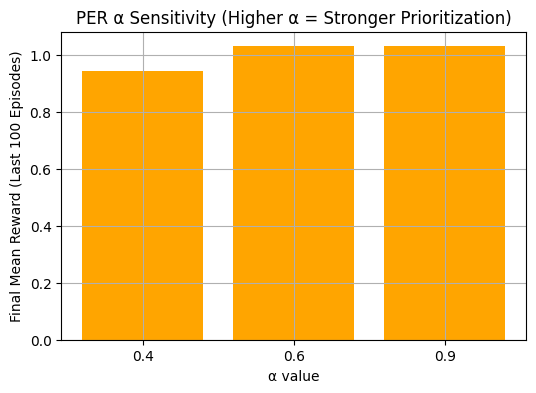

In [ ]:
alpha_results = run_per_alpha_sweep(
    alpha_values=[0.4, 0.6, 0.9],
    test_frames=5000
)

# Learning Curve Comparison and Metrics

In [ ]:
def smooth_curve(values, window=20):
    """Moving average smoothing."""
    if len(values) < window:
        return values  # not enough data to smooth
    return np.convolve(values, np.ones(window)/window, mode='valid')

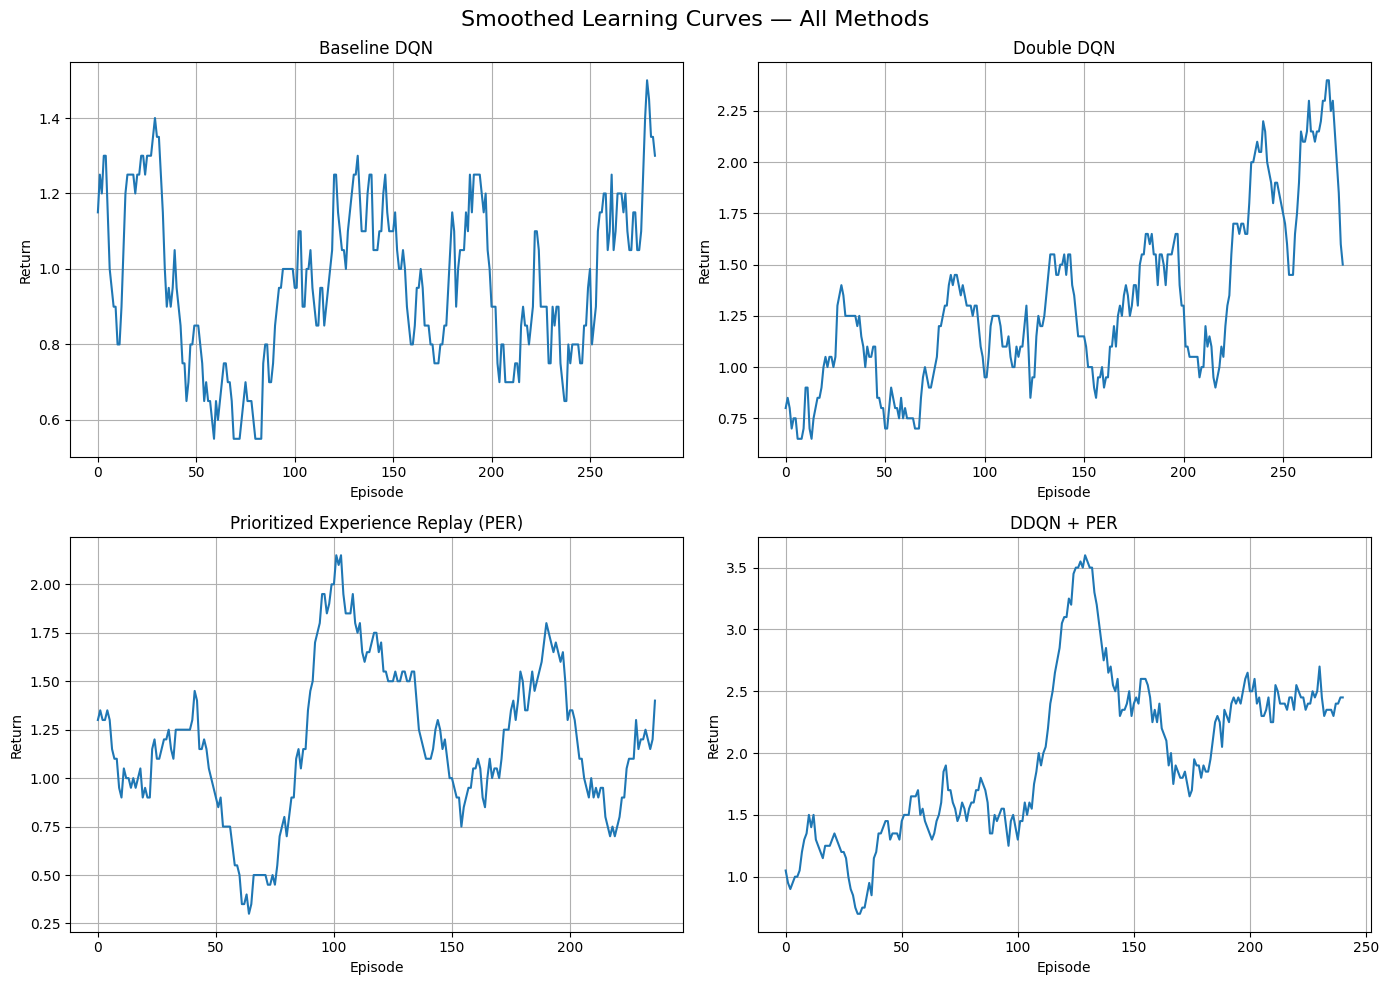

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
window = 20  # smoothing window

def sm(x): return smooth_curve(x, window)

axes[0, 0].plot(sm(baseline_rewards))
axes[0, 0].set_title("Baseline DQN")
axes[0, 0].set_xlabel("Episode")
axes[0, 0].set_ylabel("Return")
axes[0, 0].grid(True)

axes[0, 1].plot(sm(ddqn_rewards))
axes[0, 1].set_title("Double DQN")
axes[0, 1].set_xlabel("Episode")
axes[0, 1].set_ylabel("Return")
axes[0, 1].grid(True)

axes[1, 0].plot(sm(per_rewards))
axes[1, 0].set_title("Prioritized Experience Replay (PER)")
axes[1, 0].set_xlabel("Episode")
axes[1, 0].set_ylabel("Return")
axes[1, 0].grid(True)

axes[1, 1].plot(sm(ddqn_per_rewards))
axes[1, 1].set_title("DDQN + PER")
axes[1, 1].set_xlabel("Episode")
axes[1, 1].set_ylabel("Return")
axes[1, 1].grid(True)

plt.suptitle("Smoothed Learning Curves — All Methods", fontsize=16)
plt.tight_layout()
plt.show()

# Finetuning
Fine tune best performing model, which is currently DDQN + PER

In [ ]:

ddqn_per_hparams_v2 = {
    "run_type": "DDQN + PER (v2)",
    "env_name": env_name,
    "gamma": .95,                 # try adjusting to 0.97 or 0.99 if desired
    "batch_size": 128,       # you may try 64 → 32 or 128
    "replay_size": REPLAY_SIZE,
    "learning_rate": LEARNING_RATE, # maybe try 3e-4 or 1e-4 for v2
    "optimizer": "Adam",
    "epsilon_start": EPSILON_START,
    "epsilon_final": EPSILON_FINAL,
    "epsilon_decay": EPSILON_DECAY_LAST_FRAME,
    "target_sync": SYNC_TARGET_FRAMES,
    "frame_stack": 4,
    "extension": "DDQN + PER (v2)",
    "per_alpha": .7,         # you may try 0.5 or 0.7 for v2
    "per_beta_start": PER_BETA_START,
    "per_beta_end": PER_BETA_END,
    "replay_start_size": REPLAY_START_SIZE
}

best_model = "/content/drive/MyDrive/PUBLIC/Models/ALE_HumanCannonball-v5-DDQN_PER_best_6-20251122-2000-DDQN_PER_epsdec5000_rs500_sync500.dat"

ddqn_per_rewards_v2 = run_experiment(
    name="DDQN + PER (Fine-tuned v2)",
    hparams=ddqn_per_hparams_v2,
    comment="Fine-tuned from best DDQN+PER checkpoint",
    training_loop_fn=lambda: train_ddqn_per(
        load_pretrained=True,
        pretrained_path=best_model
    ),
    save_prefix="ddqn_per_v2"
)

Starting Experiment: DDQN + PER (Fine-tuned v2)
Logged change: Fine-tuned from best DDQN+PER checkpoint

=== Hyperparameters ===
+----+-------------------+------------------------+
|    | Parameter         | Value                  |
|----+-------------------+------------------------|
|  0 | run_type          | DDQN + PER (v2)        |
|  1 | env_name          | ALE/HumanCannonball-v5 |
|  2 | gamma             | 0.95                   |
|  3 | batch_size        | 128                    |
|  4 | replay_size       | 5000                   |
|  5 | learning_rate     | 0.0001                 |
|  6 | optimizer         | Adam                   |
|  7 | epsilon_start     | 1.0                    |
|  8 | epsilon_final     | 0.02                   |
|  9 | epsilon_decay     | 5000                   |
| 10 | target_sync       | 500                    |
| 11 | frame_stack       | 4                      |
| 12 | extension         | DDQN + PER (v2)        |
| 13 | per_alpha         | 0.7         

Saved rollout video (148 frames, total reward 2.00) → /content/drive/MyDrive/PUBLIC/Models/ALE_HumanCannonball-v5_pretrain_DDQN_PER.mp4


Starting DDQN + PER training...
104: done 1 games, reward 0.000, eps 0.98, speed 65.67 f/s, time 0.0 min
642: done 5 games, reward 0.600, eps 0.87, speed 162.41 f/s, time 0.0 min
1122: done 8 games, reward 1.125, eps 0.78, speed 134.73 f/s, time 0.1 min
21493: done 134 games, reward 1.650, eps 0.02, speed 126.30 f/s, time 2.8 min
31114: done 185 games, reward 2.170, eps 0.02, speed 126.25 f/s, time 4.0 min
Stopping early: hit frame limit 50000
Recording post-training DDQN+PER video...
Creating environment ALE/HumanCannonball-v5


Saved rollout video (200 frames, total reward 5.00) → /content/drive/MyDrive/PUBLIC/Models/ALE_HumanCannonball-v5_posttrain_DDQN_PER.mp4



=== DDQN + PER (Fine-tuned v2) — Summary ===
Episodes: 284
Final 100-episode mean reward: 2.26
Max episode reward: 7.00
What we hoped to improve: Fine-tuned from best DDQN+PER checkpoint



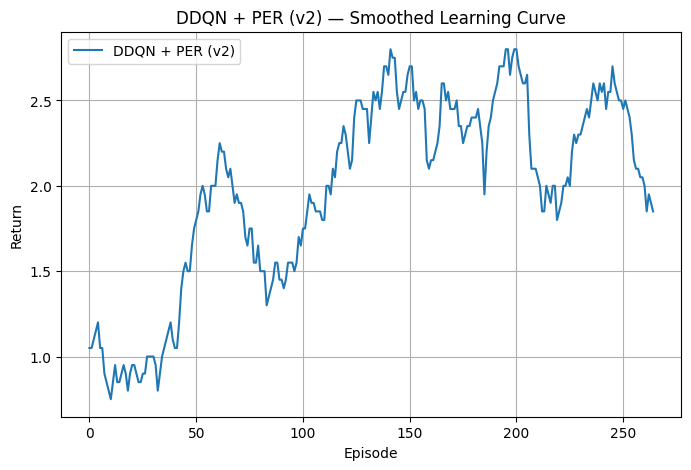

In [ ]:
smoothed_v2 = smooth_curve(ddqn_per_rewards_v2, window=20)

plt.figure(figsize=(8,5))
plt.plot(smoothed_v2, label="DDQN + PER (v2)")
plt.title("DDQN + PER (v2) — Smoothed Learning Curve")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.grid(True)
plt.legend()
plt.show()

# Fine tuning again with different parameters

...

Reading metrics from: runs/ddqn_per


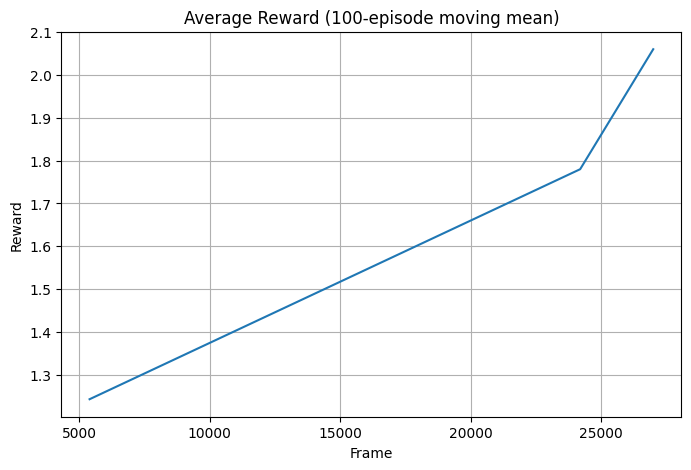

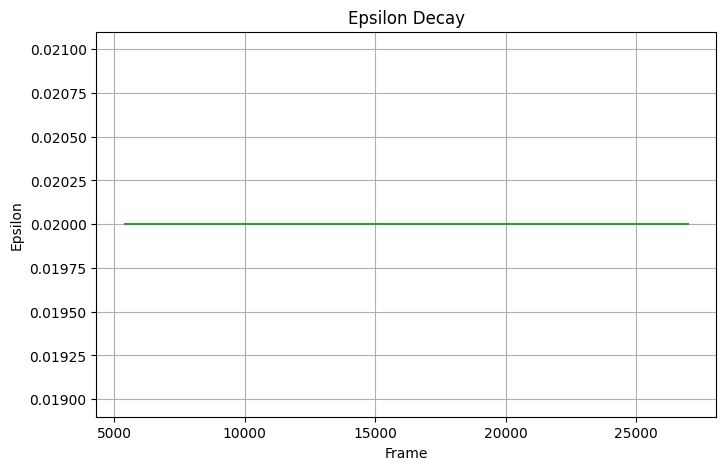

,run_name,final_reward,max_reward,mean_reward,std_reward
0,ddqn_per,2.06,2.06,1.694414,0.41505


📁 Metrics saved to: /content/drive/MyDrive/PUBLIC/Models/metrics_ddqn_per.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Post-Training Metrics Summary (Run this after training finishes)
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import os

# Path to the most recent TensorBoard log folder
# The writer object is local to the training functions, so we need to specify the log directory explicitly.
# Assuming the last executed training was DDQN + PER, its logs are in 'runs/ddqn_per'
log_dir = "runs/ddqn_per"
print(f"Reading metrics from: {log_dir}")

# Load data from TensorBoard event file
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

def extract_scalar(tag):
    if tag in ea.scalars.Keys():
        events = ea.Scalars(tag)
        steps = [e.step for e in events]
        values = [e.value for e in events]
        return pd.DataFrame({"frame": steps, tag: values})
    else:
        print(f"⚠️ Tag '{tag}' not found in logs.")
        return pd.DataFrame(columns=["frame", tag])

# Extract key metrics
reward_df = extract_scalar("reward_100")
loss_df = extract_scalar("loss")
eps_df = extract_scalar("epsilon")

# === Plot reward curve ===
if not reward_df.empty:
    plt.figure(figsize=(8,5))
    plt.plot(reward_df["frame"], reward_df["reward_100"], color='tab:blue')
    plt.title("Average Reward (100-episode moving mean)")
    plt.xlabel("Frame")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.show()


# === Plot epsilon decay ===
if not eps_df.empty:
    plt.figure(figsize=(8,5))
    plt.plot(eps_df["frame"], eps_df["epsilon"], color='tab:green')
    plt.title("Epsilon Decay")
    plt.xlabel("Frame")
    plt.ylabel("Epsilon")
    plt.grid(True)
    plt.show()

# === Compute basic summary statistics ===
if not reward_df.empty:
    summary = {
        "run_name": os.path.basename(log_dir),
        "final_reward": reward_df["reward_100"].iloc[-1],
        "max_reward": reward_df["reward_100"].max(),
        "mean_reward": reward_df["reward_100"].mean(),
        "std_reward": reward_df["reward_100"].std(),
    }
    summary_df = pd.DataFrame([summary])
    display(summary_df)

    # Save results to your Drive for later comparison
    metrics_path = os.path.join(save_dir_drive, f"metrics_{summary['run_name']}.csv")
    summary_df.to_csv(metrics_path, index=False)
    print(f"📁 Metrics saved to: {metrics_path}")

#Reflection
We selected Human Cannonball because its simple and deterministic actions make it an ideal setting for examining how Deep Q-Learning handles precise control under sparse rewards. For this specific game, improvement meant achieving higher mean returns, meaning that the agent had to improve its aim so that the performer would land in the water tower more often. These improvements became clear as we moved through the four models, with each approach addressing limitations found in the previous one. The fine-tuned version further showed that even small, focused hyperparameter changes (such as adjusting gamma, batch size, and PER parameters) could lead to notable improvements in both stability and return.

One of the primary challenges of this environment was the extremely sparse reward structure. The agent receives feedback only when it hits or misses the water tower, which makes exploration difficult or often unstable. Early models often plateaued because they did not receive enough useful transitions to learn stable policies. Double DQN helped address this by reducing value overestimation and improving how the agent evaluated its actions. PER also made learning more effective by prioritizing the rare transitions that actually provided meaningful learning signals. Together, these methods encouraged better exploration and reduced some of the instability caused by the sparse reward structure.

The project overall was successful and showed steady progress across model variations. Each algorithmic modification deepened our understanding of how sampling strategies, network updates, and exploration behaviors interact in a sparse-reward environment like Human Cannonball. The DDQN + PER model stood out as the strongest performing model, and the fine-tuned version reaffirmed the value of targeted parameter adjustments.

Several extensions would be interesting to explore. Removing the frame limit and allowing the models to train for much longer would almost certainly improve performance, but this was not feasible due to resource and time constraints. Adjusting the epsilon-decay schedule or modifying the target network sync interval may help stabilize learning even further. Additionally, experimenting with replay buffer variations (n-step returns or integrating elements from Rainbow DQN) could improve both learning speed and generalization. Reward shaping or introducing sticky actions might reduce some of the brittleness caused by sparse and delayed feedback. Pursuing these directions would likely push the agent toward even stronger performance in future iterations.

